In [1]:
import drizzlepac
import sys
sys.path.insert(0,'/data/emiln/XLSSU122/analysis/galfit/GalfitPyWrap')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy import wcs
from astropy.table import Table, hstack, join
import pickle
import os
from __future__ import division
import fnmatch
import multiprocessing as mp
from scipy.ndimage import zoom, convolve
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/emiln/anaconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars          pixtopix            pixtosky      
     resetbits            skytopix           tweakback            tweakreg      
     updatenpol


--------------
### Pull star PSF from cosmos mosaic


12239.0
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
     

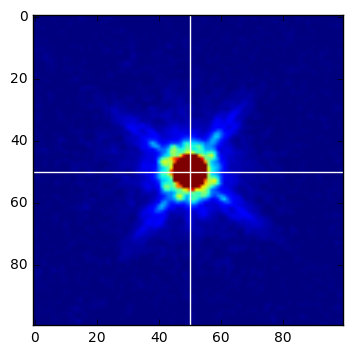

In [2]:
cosmos_mosaic_file = 'hlsp_candels_hst_wfc3_cos-tot_f125w_v1.0_drz.fits'
# starY = 9680
starY = 9679
# starX = 12290
starX = 12289
width = 100 # 100*0.06'' = 6''
COSMOS_MOSAIC = fits.open(cosmos_mosaic_file)
print starX - width/2
COSMOS_WCS = wcs.WCS(COSMOS_MOSAIC[0].header)
COSMOS_MOSAIC_cutout = COSMOS_MOSAIC[0].data[int(starX-width/2):int(starX+width/2),int(starY-width/2):int(starY+width/2)]
COSMOS_WCS_cutout = COSMOS_WCS[int(starX-width/2):int(starX+width/2),int(starY-width/2):int(starY+width/2)]

plt.imshow(COSMOS_MOSAIC_cutout,vmin=0,vmax=1)
plt.axvline(50,color='white')
plt.axhline(50,color='white')


new_hdu = fits.PrimaryHDU(COSMOS_MOSAIC_cutout)
new_hdul = fits.HDUList([new_hdu])
new_hdul[0].header = COSMOS_MOSAIC[0].header
new_hdul[0].header.update(COSMOS_WCS_cutout.to_header()) 
new_cosmos_filename = 'cosmos_star_PSF_9679_12289.fits'
new_hdul.writeto(new_cosmos_filename, clobber=True)

-------------
### Use TinyTim PSF
Take oversampled PSF, bin down to drizzled plate scale (0.06''), interpolate WFC3 charge diffusion kernel from 0.13'' plate scale to 0.06'', apply interpolated CDK to PSF

(552, 552)
0
(120, 120)
1878


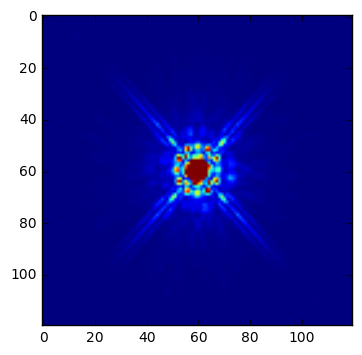

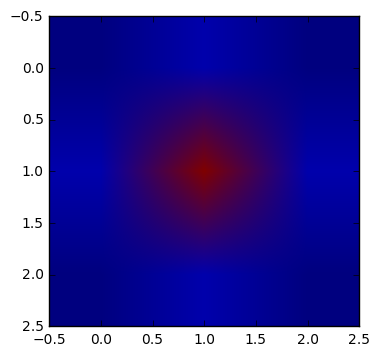

[[0.002      0.014      0.026      0.038      0.026      0.014
  0.002     ]
 [0.014      0.11111111 0.20822222 0.30533333 0.20822222 0.11111111
  0.014     ]
 [0.026      0.20822222 0.39044444 0.57266667 0.39044444 0.20822222
  0.026     ]
 [0.038      0.30533333 0.57266667 0.84       0.57266667 0.30533333
  0.038     ]
 [0.026      0.20822222 0.39044444 0.57266667 0.39044444 0.20822222
  0.026     ]
 [0.014      0.11111111 0.20822222 0.30533333 0.20822222 0.11111111
  0.014     ]
 [0.002      0.014      0.026      0.038      0.026      0.014
  0.002     ]]


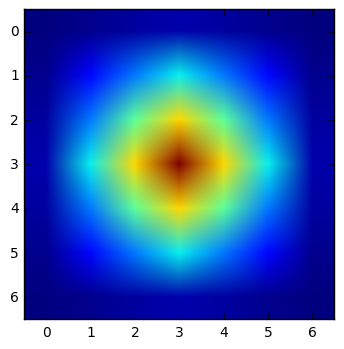

[[ 0.e+00  0.e+00 -0.e+00 ... -0.e+00  0.e+00 -0.e+00]
 [ 0.e+00  0.e+00 -0.e+00 ... -0.e+00  0.e+00 -0.e+00]
 [-0.e+00 -0.e+00  1.e-45 ...  0.e+00 -0.e+00  0.e+00]
 ...
 [ 0.e+00  0.e+00 -0.e+00 ...  0.e+00 -0.e+00  0.e+00]
 [-0.e+00 -0.e+00  0.e+00 ... -0.e+00  0.e+00 -0.e+00]
 [-0.e+00 -0.e+00  0.e+00 ...  0.e+00 -0.e+00 -0.e+00]]
[[ 9.6689594e-44 -1.2115206e-40  2.5602079e-38 ...  1.0101162e-39
  -4.7798291e-42  4.2038954e-45]
 [-1.2115206e-40  1.5251440e-37 -3.2234173e-35 ... -1.2717820e-36
   6.0173732e-39 -4.7798291e-42]
 [ 2.5602079e-38 -3.2234173e-35  6.8134510e-33 ...  2.6882107e-34
  -1.2717820e-36  1.0101162e-39]
 ...
 [-6.5613839e-40  8.2610728e-37 -1.7461724e-34 ...  3.4428000e-34
  -1.6287752e-36  1.2936605e-39]
 [ 3.1052774e-42 -3.9086866e-39  8.2610728e-37 ... -1.6287752e-36
   7.7064703e-39 -6.1222730e-42]
 [-2.8025969e-45  3.1052774e-42 -6.5613839e-40 ...  1.2936605e-39
  -6.1222730e-42  4.2038954e-45]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

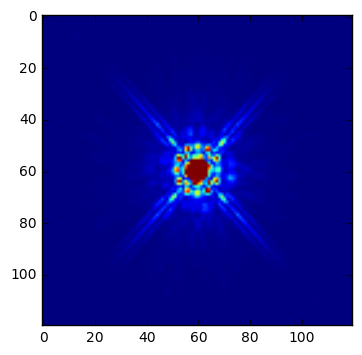

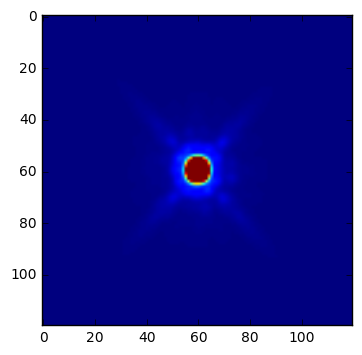

In [11]:
supersampled_psf = 'SUBSAMPLED_PSF00.fits'

SUB_PSF = fits.open(supersampled_psf)[0].data # 0.013'' pixel scale
print np.shape(SUB_PSF)
print np.sum(SUB_PSF<0)
new_PSF = zoom(SUB_PSF,zoom=0.013/0.06)
print np.shape(new_PSF)
print np.sum(new_PSF<0)

plt.imshow(new_PSF,vmin=np.percentile(new_PSF,0.1),vmax=np.percentile(new_PSF,99.5))
plt.show()

# print np.sum(SUB_PSF[0].data<0)
# new_PSF = zoom(SUB_PSF[0].data,zoom=0.013/0.13,order=0)
# print np.sum(new_PSF<0)
conv_kernel = [[0.002,0.038,0.002],[0.038,0.84,0.038],[0.002,0.038,0.002]]
plt.imshow(conv_kernel)
plt.show()
new_conv_kernel = zoom(conv_kernel,zoom=0.13/0.06, order=1)
print new_conv_kernel

plt.imshow(new_conv_kernel)
plt.show()

conv_PSF = convolve(new_PSF,new_conv_kernel,mode='constant',cval=0.0)

# print np.sum(new_PSF<0)
# print new_PSF.shape
print new_PSF
print conv_PSF

conv_PSF[abs(conv_PSF)<1e-15] = 0
print conv_PSF
print np.sum(conv_PSF<0)
# plt.imshow(new_PSF)

# conv_kernel = [[0.002,0.038,0.002],[0.038,0.84,0.038],[0.002,0.038,0.002]]
# conv_PSF = convolve(new_PSF,conv_kernel,mode='constant',cval=0.0)
# plt.imshow(new_PSF,vmin=1e-7,vmax=np.percentile(new_PSF,99.7))
plt.imshow(new_PSF,vmin=np.percentile(new_PSF,0.1),vmax=np.percentile(new_PSF,99.5))
plt.show()
plt.imshow(conv_PSF,vmin=np.percentile(conv_PSF,0.1),vmax=np.percentile(conv_PSF,99.5))


In [12]:
# zoom is doing weird things, try skimage.transform.recsale --> https://github.com/scipy/scipy/issues/7324

from skimage.transform import rescale

(552, 552)
0
(120, 120)
0


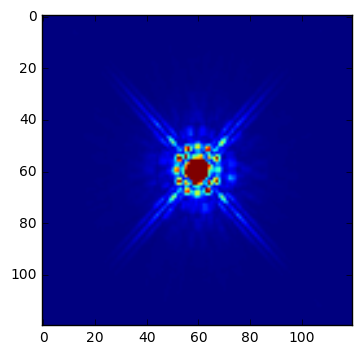

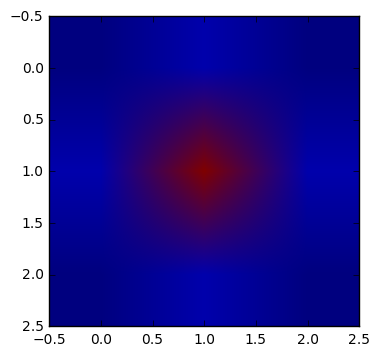

[[0.002      0.00510204 0.01612245 0.02714286 0.01612245 0.00510204
  0.002     ]
 [0.00510204 0.02791837 0.0902449  0.15257143 0.0902449  0.02791837
  0.00510204]
 [0.01612245 0.0902449  0.29326531 0.49628571 0.29326531 0.0902449
  0.01612245]
 [0.02714286 0.15257143 0.49628571 0.84       0.49628571 0.15257143
  0.02714286]
 [0.01612245 0.0902449  0.29326531 0.49628571 0.29326531 0.0902449
  0.01612245]
 [0.00510204 0.02791837 0.0902449  0.15257143 0.0902449  0.02791837
  0.00510204]
 [0.002      0.00510204 0.01612245 0.02714286 0.01612245 0.00510204
  0.002     ]]


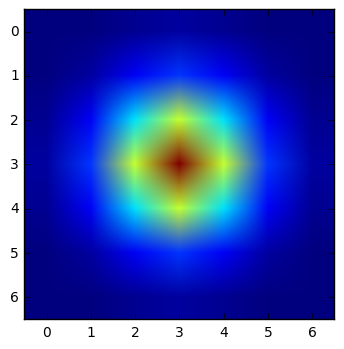

0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


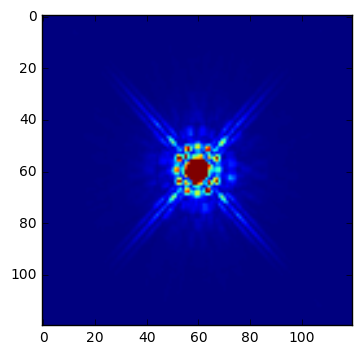

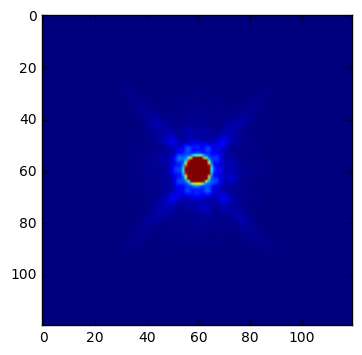

In [18]:
supersampled_psf = 'SUBSAMPLED_PSF00.fits'

SUB_PSF = fits.open(supersampled_psf)[0].data # 0.013'' pixel scale
print np.shape(SUB_PSF)
print np.sum(SUB_PSF<0)
new_PSF = rescale(SUB_PSF,0.013/0.06)
print np.shape(new_PSF)
print np.sum(new_PSF<0)

plt.imshow(new_PSF,vmin=np.percentile(new_PSF,0.1),vmax=np.percentile(new_PSF,99.5))
plt.show()

# print np.sum(SUB_PSF[0].data<0)
# new_PSF = zoom(SUB_PSF[0].data,zoom=0.013/0.13,order=0)
# print np.sum(new_PSF<0)
conv_kernel = np.array([[0.002,0.038,0.002],[0.038,0.84,0.038],[0.002,0.038,0.002]])
plt.imshow(conv_kernel)
plt.show()
new_conv_kernel = rescale(conv_kernel,0.13/0.06)
print new_conv_kernel

plt.imshow(new_conv_kernel)
plt.show()

conv_PSF = convolve(new_PSF,new_conv_kernel,mode='constant',cval=0.0)

print np.sum(conv_PSF<0)

# print np.sum(new_PSF<0)
# print new_PSF.shape
print new_PSF
print conv_PSF

# conv_kernel = [[0.002,0.038,0.002],[0.038,0.84,0.038],[0.002,0.038,0.002]]
# conv_PSF = convolve(new_PSF,conv_kernel,mode='constant',cval=0.0)
# plt.imshow(new_PSF,vmin=1e-7,vmax=np.percentile(new_PSF,99.7))
plt.imshow(new_PSF,vmin=np.percentile(new_PSF,0.1),vmax=np.percentile(new_PSF,99.5))
plt.show()
plt.imshow(conv_PSF,vmin=np.percentile(conv_PSF,0.1),vmax=np.percentile(conv_PSF,99.5))


new_hdu = fits.PrimaryHDU(conv_PSF)
new_hdul = fits.HDUList([new_hdu])
new_hdul[0].header = fits.open(supersampled_psf)[0].header
# new_hdul[0].header.update(COSMOS_WCS_cutout.to_header()) 
new_PSF_filename = 'resampled_CDKinterp_convolved_PSF.fits'
new_hdul.writeto(new_PSF_filename, clobber=True)

---------------
### Misc

In [2]:
def rebin( a, newshape ):
        '''Rebin an array to a new shape.
        '''
        assert len(a.shape) == len(newshape)

        slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
        coordinates = np.mgrid[slices]
        indices = coordinates.astype('i')   #choose the biggest smaller integer index
        return a[tuple(indices)]

In [50]:
%qtconsole

In [51]:
np.percentile(conv_PSF,99)

1.3095440090182845e-05

0
0
2017
[[ 0.0000000e+00 -5.8060163e-27 -3.3321485e-27 ... -3.7688939e-27
  -5.7081975e-27 -1.0097420e-28]
 [ 1.9558702e-25 -3.1542607e-13 -1.9714129e-13 ... -7.9195771e-14
  -1.2671324e-13  1.2621774e-29]
 [ 1.2217878e-25 -1.9714129e-13 -1.2321330e-13 ... -4.9497360e-14
  -7.9195771e-14 -1.0097420e-28]
 ...
 [ 1.3108807e-25 -2.6432635e-13 -1.6520396e-13 ... -9.2430966e-14
  -1.4788955e-13  5.0536402e-29]
 [ 2.0876415e-25 -4.2292214e-13 -2.6432635e-13 ... -1.4788955e-13
  -2.3662328e-13  1.2621774e-29]
 [ 2.0194839e-28  6.8157582e-28  6.0584518e-28 ... -1.0205888e-29
  -3.1554436e-29 -3.0292259e-28]]


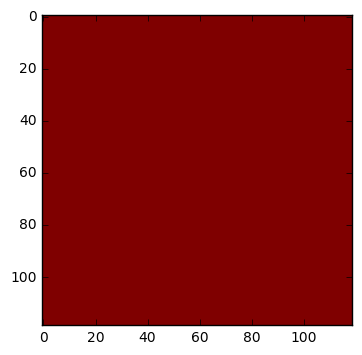

In [78]:
print np.sum(SUB_PSF[0].data<0)
new_PSF = zoom(SUB_PSF[0].data,zoom=0.013/0.13,order=0)
print np.sum(new_PSF<0)
conv_kernel = [[0.002,0.038,0.002],[0.038,0.84,0.038],[0.002,0.038,0.002]]
conv_PSF = convolve(new_PSF,conv_kernel,mode='constant',cval=0.0)
new_PSF = zoom(conv_PSF,zoom=0.13/0.06)
print np.sum(new_PSF<0)
# print new_PSF.shape
print new_PSF
# plt.imshow(new_PSF)

# conv_kernel = [[0.002,0.038,0.002],[0.038,0.84,0.038],[0.002,0.038,0.002]]
# conv_PSF = convolve(new_PSF,conv_kernel,mode='constant',cval=0.0)
# plt.imshow(new_PSF,vmin=1e-7,vmax=np.percentile(new_PSF,99.7))
plt.imshow(new_PSF,vmin=-1000,vmax=0)

In [68]:
new_hdu = fits.PrimaryHDU(new_PSF)
new_hdul = fits.HDUList([new_hdu])
new_hdul[0].header = SUB_PSF[0].header
# new_hdul[0].header.update(COSMOS_WCS_cutout.to_header()) 
new_PSF_filename = 'resampled_convolved_PSF2.fits'
new_hdul.writeto(new_PSF_filename, clobber=True)

In [36]:
0.013* 552 / 0.06

119.6

In [28]:
supersampled_psf = 'SUBSAMPLED_PSF00.fits'
OG_PSF_file = 'f125w_400_400_6arcsec_psf.fits'
cosmos_cutout_file = 'cosmos_cutout.fits'

OG_PSF = fits.open(OG_PSF_file)
SUB_PSF = fits.open(supersampled_psf)
COSMOS_CUTOUT = fits.open(cosmos_cutout_file)
COSMOS_WCS = wcs.WCS(COSMOS_CUTOUT[0].header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


In [31]:
OG_PSF[0].header
OG_PSF[0].data.shape

print SUB_PSF[0].data.shape
print SUB_PSF[0].header

(552, 552)
SIMPLE  =                    T                                                  BITPIX  =                  -32                                                  NAXIS   =                    2                                                  NAXIS1  =                  552                                                  NAXIS2  =                  552                                                  EXTEND  =                    F                                                  CREATED = 'Fri Jul 26 16:38:13 2019'  / Time and date file was created          INSTRUME= 'WFC3_IR'            / Simulated instrument                           FOCUS   =               0.0076 / PSF RMS focus (waves @ 547 nm)                 X_COMA  =              -0.0293 / PSF RMS X-coma (waves @ 547 nm)                Y_COMA  =               0.0312 / PSF RMS Y-coma (waves @ 547 nm)                X_ASTIG =               0.0223 / PSF RMS 0d astig (waves @ 547 nm)              Y_ASTIG =               0.000

In [32]:
COSMOS_WCS

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.1163213  2.200973097  
CRPIX : -2646.5  -7911.5  
PC1_1 PC1_2  : -1.666667e-05  0.0  
PC2_1 PC2_2  : 0.0  1.666667e-05  
CDELT : 1.0  1.0  
NAXIS    : 400 400

In [16]:
# COSMOS_MOSAIC_cutout = COSMOS_MOSAIC[0].data[7000:7500,7000:7500]
# COSMOS_WCS_cutout = COSMOS_WCS[7000:7500,7000:7500]

# new_hdu = fits.PrimaryHDU(COSMOS_MOSAIC_cutout)
# new_hdul = fits.HDUList([new_hdu])
# new_hdul[0].header = COSMOS_MOSAIC[0].header
# new_hdul[0].header.update(COSMOS_WCS_cutout.to_header()) 
# new_cosmos_filename = 'cosmos_cutout_500_1000.fits'
# new_hdul.writeto(new_cosmos_filename, clobber=True)

INFO: 
        Inconsistent SIP distortion information is present in the current WCS:
        SIP coefficients were detected, but CTYPE is missing "-SIP" suffix,
        therefore the current WCS is internally inconsistent.

        Because relax has been set to True, the resulting output WCS will have
        "-SIP" appended to CTYPE in order to make the header internally consistent.

        However, this may produce incorrect astrometry in the output WCS, if
        in fact the current WCS is already distortion-corrected.

        Therefore, if current WCS is already distortion-corrected (eg, drizzled)
        then SIP distortion components should not apply. In that case, for a WCS
        that is already distortion-corrected, please remove the SIP coefficients
        from the header.

         [astropy.wcs.wcs]


In [ ]:
drizzlepac.adrizzle.drizSeparate(OG_PSF_file,COSMOS_WCS,)

In [21]:
drizzlepac.adrizzle.drizzle(OG_PSF_file,cosmos_cutout_file,driz_separate=True)

The following input parameters were not recognized as valid inputs:
    driz_separate

Please check the spelling of the parameter(s) and try again...


ValueError: 

In [22]:
drizzlepac.astrodrizzle.AstroDrizzle(input=OG_PSF_file,driz_sep_refimage=cosmos_cutout_file)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 1.1.16(30-Dec-2013) started at: 15:43:15.407 (08/08/2019)

==== Processing Step  Initialization  started at  15:43:15.411 (08/08/2019)
Preserving original of:  f125w_400_400_6arcsec_psf.fits as  OrIg_files/f125w_400_400_6arcsec_psf.fits


##############################################################################
#                                                                            #
# ERROR:                                                                     #
# AstroDrizzle Version 1.1.16 encountered a problem!  Processing terminated  #
# at 15:43:15.468 (08/08/2019).                                              #
#                                                                            #
##############################################################################



   --------------------          --------------------
                   Step          Elapsed time
   --------------------          --------------------

         Initialization          0.0000 sec.
   ====================          ====================
                  Total          0.0000 sec.
Trailer file written to:  astrodrizzle.log


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

TypeError: exceptions must be old-style classes or derived from BaseException, not NoneType